# add ACS census information to FEMA zipcode catalog

In [1]:
import os
import numpy as np
import astropy.table as aTable

In [2]:
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read FEMA data

In [3]:
fema = aTable.Table.read('/Users/chahah/data/noah/fema.zipcode.fsf.csv', format='csv')
print(len(fema))

198492


In [4]:
fema[1:5]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
1001,2014,8,MA,-72.6,42.1,0.0,11.0,1.0,1.0,590.26,0.0,250000,100000,590.26,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540
1001,2011,8,MA,-72.6,42.1,0.0,11.0,1.0,2.0,9320.56,0.0,262000,5000,9320.56,267000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540
1001,2011,4,MA,-72.6,42.0,0.0,11.0,1.0,1.0,10545.77,1473.46,250000,100000,12019.23,350000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540
1001,1987,3,MA,-72.6,42.1,0.0,11.0,0.0,1.0,1185.9,0.0,50000,18000,1185.9,68000,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540


## read in ACS census data: 2016 - 2020

In [5]:
census2018 = aTable.Table.read('/Users/chahah/data/noah/ACS2016_20new.csv', format='csv')[1:]

In [6]:
income = census2018['Median Household Income (In 2020 Inflation Adjusted Dollars)']
population = census2018['Total Population']
population_density = census2018['Population Density (Per Sq. Mile)']

In [7]:
renter_fraction = (
    np.array(census2018['Total Population in Occupied Housing Units: Renter Occupied'].data).astype(float) / 
    np.array(census2018['Total Population'].data).astype(float))
renter_fraction = aTable.MaskedColumn(renter_fraction, dtype=float)
renter_fraction.mask = np.array(census2018['Total Population'].data).astype(float) == 0.

/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
educated_fraction = (
    np.array(census2018['Population 25 Years and Over: Bachelor\'s Degree or More'].data).astype(float) / 
    np.array(census2018['Population 25 Years and Over:'].data).astype(float))

educated_fraction = aTable.MaskedColumn(educated_fraction, dtype=float)
educated_fraction.mask = np.array(census2018['Population 25 Years and Over:'].data).astype(float) == 0.

/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
acs2018 = aTable.Table()
acs2018['zipcode'] = np.array([int(name.split(' ')[1]) for name in census2018['Qualifying Name']])
acs2018['2018.population'] = population
acs2018['2018.median_household_income'] = income
acs2018['2018.renter_fraction'] = renter_fraction
acs2018['2018.educated_fraction'] = educated_fraction

In [10]:
comb_mask = (acs2018['2018.median_household_income'].mask | acs2018['2018.renter_fraction'].mask | acs2018['2018.educated_fraction'].mask)

In [11]:
print('%i of %i entries do not have income data' % (np.sum(comb_mask), len(acs2018)))
print('%.2f percent' % (np.sum(income.mask)/len(income)*100.))

2557 of 33120 entries do not have income data
7.72 percent


In [12]:
acs2018 = acs2018[~comb_mask]

## read in ACS census data: 2012 - 2016

In [13]:
census2014 = aTable.Table.read('/Users/chahah/data/noah/ACS2012_16socexplnew.csv', format='csv')[1:]

In [14]:
census2014[::100][:5]

FIPS,Geographic Identifier,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,US,Region,Division,State (Census Code),State (FIPS),County,County Subdivision (FIPS),Place (FIPS Code),Place (State FIPS + Place FIPS),Census Tract,Block Group,Consolidated City,American Indian Area/Alaska Native Area/Hawaiian Home Land (Census),American Indian Area/Alaska Native Area/Hawaiian Home Land (FIPS),American Indian Trust Land/Hawaiian Home Land Indicator,American Indian Tribal Subdivision (Census),American Indian Tribal Subdivision (FIPS),Alaska Native Regional Corporation (FIPS),Metropolitan and Micropolitan Statistical Area,Combined Statistical Area,Metropolitan Division,Metropolitan Area Central City,Metropolitan/Micropolitan Indicator Flag,New England City and Town Combined Statistical Area,New England City and Town Area,New England City and Town Area Division,Urban Area,Urban Area Central Place,Current Congressional District ***,State Legislative District Upper,State Legislative District Lower,Voting District,ZIP Code Tabulation Area (3-digit),ZIP Code Tabulation Area (5-digit),Subbarrio (FIPS),School District (Elementary),School District (Secondary),School District (Unified),Urban/Rural,Principal City Indicator,Traffic Analysis Zone,Urban Growth Area,Tribal Tract,Tribal Block Group,Public Use Microdata Area - 5% File,Public Use Microdata Area - 1% File,Total Population,Total Population_1,Population Density (Per Sq. Mile),Area (Land),Total Population:,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate or More (Includes Equivalency),Population 25 Years and Over: Some College or More,Population 25 Years and Over: Bachelor's Degree or More,Population 25 Years and Over: Master's Degree or More,Population 25 Years and Over: Professional School Degree or More,Population 25 Years and Over: Doctorate Degree,Renter-Occupied Housing Units,Renter-Occupied Housing Units: Less than High School Graduate,Renter-Occupied Housing Units: High School Graduate (Including Equivalency),Renter-Occupied Housing Units: Some College or Associate's Degree,Renter-Occupied Housing Units: Bachelor's Degree or Higher,Median Household Income (In 2016 Inflation Adjusted Dollars),Median Household Income (In 2016 Inflation Adjusted Dollars):,Median Household Income (In 2016 Inflation Adjusted Dollars): White Alone Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): Black or African American Alone Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): American Indian and Alaska Native Alone Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): Asian Alone,Median Household Income (In 2016 Inflation Adjusted Dollars): Native Hawaiian and Other Pacific Islander Alone Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): Some Other Race Alone Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): Two or More Races Householder,Median Household Income (In 2016 Inflation Adjusted Dollars): Hispanic or Latino Householder,"Median Household Income (In 2016 Inflation Adjusted Dollars): White Alone Householder, Not Hispanic or Latino",Households:,Households: with Earnings,Households: No Earnings,Per Capita Income (In 2016 Inflation Adjusted Dollars),Lowest Quintile,Second Quintile,Third Quintile,Fourth Quintile,Lower Limit of Top 5 Percent,Occupied Housing Units:,Occupied Housing Units: Owner Occupied,Occupied Housing Units: Renter Occupied,Housing Units:,Housing Units: Occupied,Housing Units: Vacant,Vacant Housin

In [15]:
income = census2014['Median Household Income (In 2016 Inflation Adjusted Dollars)']
population = census2014['Total Population']
population_density = census2014['Population Density (Per Sq. Mile)']

renter_fraction = (
    np.array(census2014['Total Population in Occupied Housing Units: Renter Occupied'].data).astype(float) / 
    np.array(census2014['Total Population'].data).astype(float))
renter_fraction = aTable.MaskedColumn(renter_fraction, dtype=float)
renter_fraction.mask = np.array(census2014['Total Population'].data).astype(float) == 0.

educated_fraction = (
    np.array(census2014['Population 25 Years and Over: Bachelor\'s Degree or More'].data).astype(float) / 
    np.array(census2014['Population 25 Years and Over:'].data).astype(float))

educated_fraction = aTable.MaskedColumn(educated_fraction, dtype=float)
educated_fraction.mask = np.array(census2014['Population 25 Years and Over:'].data).astype(float) == 0.

/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [16]:
acs2014 = aTable.Table()
acs2014['zipcode'] = np.array([int(name.split(' ')[0]) for name in census2014['Qualifying Name']])
acs2014['2014.population'] = population
acs2014['2014.median_household_income'] = income
acs2014['2014.renter_fraction'] = renter_fraction
acs2014['2014.educated_fraction'] = educated_fraction

In [17]:
comb_mask = (acs2014['2014.median_household_income'].mask | 
             acs2014['2014.renter_fraction'].mask | 
             acs2014['2014.educated_fraction'].mask)

In [18]:
print('%i of %i entries do not have income data' % (np.sum(comb_mask), len(acs2014)))
print('%.2f percent' % (np.sum(income.mask)/len(income)*100.))

acs2014 = acs2014[~comb_mask]

2008 of 33120 entries do not have income data
6.06 percent


## read ACS census data: 2008 - 2012

In [19]:
census2010 = aTable.Table.read('/Users/chahah/data/noah/ACS2008_12socialexplorer.csv', format='csv')[1:]

In [20]:
census2010[::100][:5]

FIPS,Geographic Identifier,Name of Area,Qualifying Name,State/U.S.-Abbreviation (USPS),Summary Level,Geographic Component,File Identification,Logical Record Number,US,Region,Division,State (Census Code),State (FIPS),County,County Subdivision (FIPS),Place (FIPS Code),Place (State FIPS + Place FIPS),Census Tract,Block Group,Consolidated City,American Indian Area/Alaska Native Area/Hawaiian Home Land (Census),American Indian Area/Alaska Native Area/Hawaiian Home Land (FIPS),American Indian Trust Land/Hawaiian Home Land Indicator,American Indian Tribal Subdivision (Census),American Indian Tribal Subdivision (FIPS),Alaska Native Regional Corporation (FIPS),Metropolitan and Micropolitan Statistical Area,Combined Statistical Area,Metropolitan Division,Metropolitan Area Central City,Metropolitan/Micropolitan Indicator Flag,New England City and Town Combined Statistical Area,New England City and Town Area,New England City and Town Area Division,Urban Area,Urban Area Central Place,Current Congressional District ***,State Legislative District Upper,State Legislative District Lower,Voting District,ZIP Code Tabulation Area (3-digit),ZIP Code Tabulation Area (5-digit),Subbarrio (FIPS),School District (Elementary),School District (Secondary),School District (Unified),Urban/Rural,Principal City Indicator,Traffic Analysis Zone,Urban Growth Area,Tribal Tract,Tribal Block Group,Public Use Microdata Area - 5% File,Public Use Microdata Area - 1% File,Total Population,Total Population_1,Population Density (Per Sq. Mile),Area (Land),Total Population:,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate or More (Includes Equivalency),Population 25 Years and Over: Some College or More,Population 25 Years and Over: Bachelor's Degree or More,Population 25 Years and Over: Master's Degree or More,Population 25 Years and Over: Professional School Degree or More,Population 25 Years and Over: Doctorate Degree,Renter-Occupied Housing Units,Renter-Occupied Housing Units: Less than High School Graduate,Renter-Occupied Housing Units: High School Graduate (Including Equivalency),Renter-Occupied Housing Units: Some College or Associate's Degree,Renter-Occupied Housing Units: Bachelor's Degree or Higher,Median Household Income (In 2012 Inflation Adjusted Dollars),Median Household Income (In 2012 Inflation Adjusted Dollars):,Median Household Income (In 2012 Inflation Adjusted Dollars): White Alone Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): Black or African American Alone Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): American Indian and Alaska Native Alone Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): Asian Alone,Median Household Income (In 2012 Inflation Adjusted Dollars): Native Hawaiian and Other Pacific Islander Alone Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): Some Other Race Alone Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): Two or More Races Householder,Median Household Income (In 2012 Inflation Adjusted Dollars): Hispanic or Latino Householder,"Median Household Income (In 2012 Inflation Adjusted Dollars): White Alone Householder, Not Hispanic or Latino",Households:,Households: with Earnings,Households: No Earnings,Per Capita Income (In 2012 Inflation Adjusted Dollars),Lowest Quintile,Second Quintile,Third Quintile,Fourth Quintile,Lower Limit of Top 5 Percent,Occupied Housing Units:,Occupied Housing Units: Owner Occupied,Occupied Housing Units: Renter Occupied,Housing Units:,Housing Units: Occupied,Housing Units: Vacant,Vacant Housin

In [21]:
income = census2010['Median Household Income (In 2012 Inflation Adjusted Dollars)']
population = census2010['Total Population']
population_density = census2010['Population Density (Per Sq. Mile)']

renter_fraction = (
    np.array(census2010['Total Population in Occupied Housing Units: Renter Occupied'].data).astype(float) / 
    np.array(census2010['Total Population'].data).astype(float))
renter_fraction = aTable.MaskedColumn(renter_fraction, dtype=float)
renter_fraction.mask = np.array(census2010['Total Population'].data).astype(float) == 0.

educated_fraction = (
    np.array(census2010['Population 25 Years and Over: Bachelor\'s Degree or More'].data).astype(float) / 
    np.array(census2010['Population 25 Years and Over:'].data).astype(float))

educated_fraction = aTable.MaskedColumn(educated_fraction, dtype=float)
educated_fraction.mask = np.array(census2010['Population 25 Years and Over:'].data).astype(float) == 0.

/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/opt/anaconda3/envs/noah/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [22]:
acs2010 = aTable.Table()
acs2010['zipcode'] = np.array([int(name.split(' ')[0]) for name in census2010['Qualifying Name']])
acs2010['2010.population'] = population
acs2010['2010.median_household_income'] = income
acs2010['2010.renter_fraction'] = renter_fraction
acs2010['2010.educated_fraction'] = educated_fraction

In [23]:
comb_mask = (acs2010['2010.median_household_income'].mask | 
             acs2010['2010.renter_fraction'].mask | 
             acs2010['2010.educated_fraction'].mask)

In [24]:
print('%i of %i entries do not have income data' % (np.sum(comb_mask), len(acs2010)))
print('%.2f percent' % (np.sum(income.mask)/len(income)*100.))

acs2010 = acs2010[~comb_mask]

872 of 33120 entries do not have income data
2.62 percent


## join all the tables

In [25]:
comb = aTable.join(fema, acs2018, keys='zipcode', join_type='left')
comb = aTable.join(comb, acs2014, keys='zipcode', join_type='left')
comb = aTable.join(comb, acs2010, keys='zipcode', join_type='left')

In [26]:
comb[::1000][:10]

reportedZipcode,yearOfLoss,monthOfLoss,state,longitude,latitude,crs_treat,communityRatingSystemDiscount,primaryResidence,policyCount,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,amountPaidOnTotalClaim,totalTotalInsuranceCoverage,zipcode,count_property,count_fema_sfha,pct_fema_sfha,count_fs_risk_2020_5,pct_fs_risk_2020_5,count_fs_risk_2050_5,pct_fs_risk_2050_5,count_fs_risk_2020_100,pct_fs_risk_2020_100,count_fs_risk_2050_100,pct_fs_risk_2050_100,count_fs_risk_2020_500,pct_fs_risk_2020_500,count_fs_risk_2050_500,pct_fs_risk_2050_500,pct_fs_fema_difference_2020,avg_risk_score_all,avg_risk_score_2_10,avg_risk_fsf_2020_100,avg_risk_fsf_2020_500,avg_risk_score_sfha,avg_risk_score_no_sfha,count_floodfactor1,count_floodfactor2,count_floodfactor3,count_floodfactor4,count_floodfactor5,count_floodfactor6,count_floodfactor7,count_floodfactor8,count_floodfactor9,count_floodfactor10,2018.population,2018.median_household_income,2018.renter_fraction,2018.educated_fraction,2014.population,2014.median_household_income,2014.renter_fraction,2014.educated_fraction,2010.population,2010.median_household_income,2010.renter_fraction,2010.educated_fraction
int64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str13,str13,float64,float64,str13,str13,float64,float64,str13,str13,float64,float64
1001,2005,10,MA,-72.6,42.1,0.0,11.0,0.6666666666666666,3.0,5958.55,0.0,455800,26400,5958.55,482200,1001,5343,499,9.3,574,10.7,673,12.6,1208,22.6,1228,23.0,1478,27.7,1530,28.6,13.3,2.82,7.34,8.34,7.51,9.65,2.11,3813,52,104,122,40,279,234,15,144,540,16064,66088,0.21358316733067728,0.3477663785443089,17423,56714,0.21735636801928485,0.27717140661029976,17380,63682,0.18601841196777905,0.24933451641526175
1845,1998,6,MA,-71.1,42.6,0.0,11.0,0.0,1.0,1792.11,470.4,100000,25000,2262.5099999999998,125000,1845,8276,342,4.1,232,2.8,247,3.0,762,9.2,794,9.6,988,11.9,1018,12.3,5.1,1.7,6.64,7.62,6.79,5.2,1.54,7255,34,58,121,43,279,180,28,96,182,31262,113916,0.23910818245793616,0.6124180105538295,29705,102008,0.20488133310890422,0.5964559001208216,28114,97044,0.1708757202817102,0.5528379997821113
2045,2015,1,MA,-70.86666666666666,42.300000000000004,1.0,7.0,0.5,124.0,140853.49000000002,1111.3700000000001,30341600,172300,141964.86000000002,30513900,2045,4747,2983,62.8,1168,24.6,2307,48.6,2978,62.7,3170,66.8,3199,67.4,3381,71.2,-0.1,5.76,7.67,8.18,7.96,7.71,2.46,1357,83,96,54,161,674,429,97,1265,531,10478,105403,0.18572246611948845,0.5017194355508123,10437,78114,0.27354603813356326,0.44029495718363465,10342,73396,0.2137884355057049,0.378358301349511
2190,1996,10,MA,-70.95,42.2,0.0,11.0,0.0,2.0,7211.06,1352.6,132400,18000,8563.66,150400,2190,5395,116,2.2,2,0.0,3,0.1,348,6.5,388,7.2,514,9.5,533,9.9,4.3,1.45,5.52,6.37,5.65,4.72,1.37,4862,19,42,79,39,247,85,6,16,0,17466,87424,0.2780258788503378,0.42634528287403084,16886,80139,0.2547080421651072,0.3547734627831715,16176,78532,0.20839515331355093,0.34660805103008363
2664,1991,8,MA,-70.20666666666668,41.620000000000005,0.0,11.0,0.26666666666666666,15.0,166251.79000000004,40587.77,1758900,266200,206839.56000000003,2025100,2664,6453,1416,21.9,98,1.5,585,9.1,866,13.4,1122,17.4,1319,20.4,2184,33.8,-8.5,2.15,4.41,6.85,5.97,4.15,1.59,4269,759,224,223,154,433,172,32,154,33,8565,66283,0.25125510799766493,0.2903908564978129,9049,52696,0.23251187976571996,0.3104282259211837,9562,49698,0.2678309976992261,0.28992532424996725
2893,1979,1,RI,-71.5,41.7,0.0,11.0,0.0,1.0,4247.2,0.0,58100,0,4247.2,58100,2893,9907,369,3.7,337,3.4,359,3.6,1147,11.6,1217,12.3,1468,14.8,1534,15.5,7.9,1.84,6.45,7.38,6.62,7.55,1.62,8372,68,107,146,90,509,175,41,191,208,29283,60813,0.4248198613530034,0.2459999077788537,29450,51332,0.4

In [27]:
for year in [2010, 2014, 2018]: 
    print('%i of %i zipcodes dont have %s census values' % 
      (len(np.unique(comb['zipcode'][comb['%s.population' % year].mask])), len(np.unique(comb['zipcode'])), year))
print('%i of %i zipcodes dont have census values' % 
      (len(np.unique(comb['zipcode'][comb['2010.population'].mask | comb['2014.population'].mask | comb['2018.population'].mask])), len(np.unique(comb['zipcode']))))    

181 of 20523 zipcodes dont have 2010 census values
559 of 20523 zipcodes dont have 2014 census values
755 of 20523 zipcodes dont have 2018 census values
947 of 20523 zipcodes dont have census values


(20.0, 50.0)

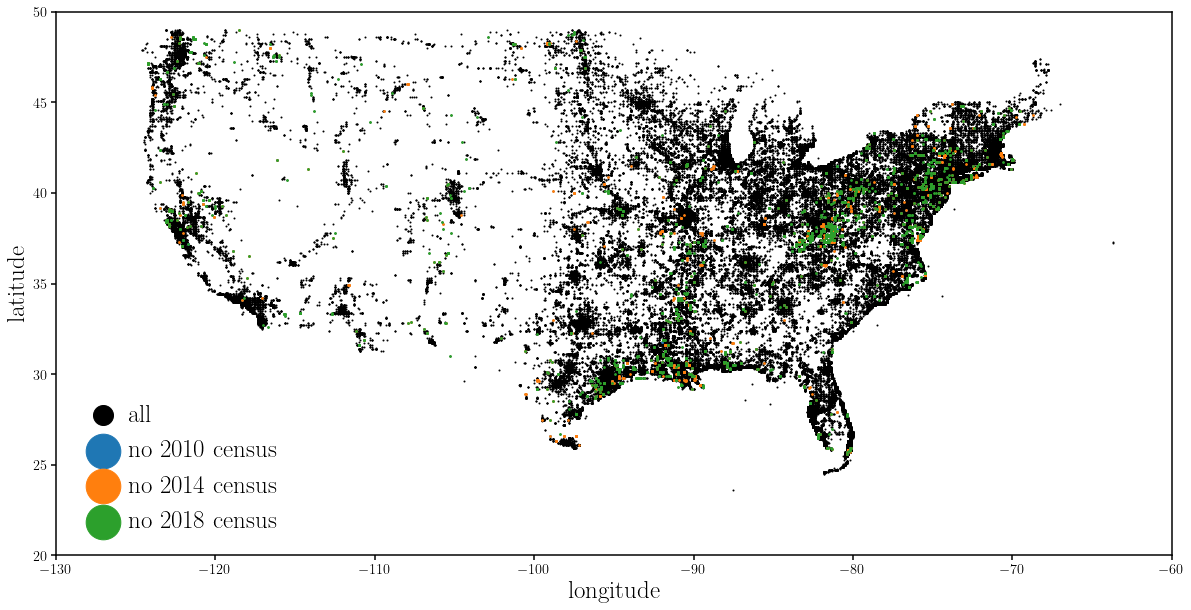

In [28]:
fig = plt.figure(figsize=(20,10))
sub = fig.add_subplot(111)
sub.scatter(comb['longitude'], comb['latitude'], s=1, c='k', rasterized=True, label='all')
sub.scatter(comb['longitude'][comb['2010.population'].mask], comb['latitude'][comb['2010.population'].mask], s=3, c='C0', rasterized=True, label='no 2010 census')
sub.scatter(comb['longitude'][comb['2014.population'].mask], comb['latitude'][comb['2014.population'].mask], s=3, c='C1', rasterized=True, label='no 2014 census')
sub.scatter(comb['longitude'][comb['2018.population'].mask], comb['latitude'][comb['2018.population'].mask], s=3, c='C2', rasterized=True, label='no 2018 census')
sub.legend(loc='lower left', markerscale=20, handletextpad=0., fontsize=25)
sub.set_xlabel('longitude', fontsize=25)
sub.set_xlim(-130., -60)
sub.set_ylabel('latitude', fontsize=25)
sub.set_ylim(20, 50)

In [29]:
combined = comb[~(comb['2010.population'].mask | comb['2014.population'].mask | comb['2018.population'].mask)]

In [30]:
combined.write('/Users/chahah/data/noah/fema.zipcode.fsf.acs.csv', format='csv', overwrite=True)